# Market Bandit

How well could you invest in the public markets, if you only had one macroeconomic signal *inflation* and could only update your investments once each year?

The following shows how to use a [*contextual bandit*](https://rllib.readthedocs.io/en/latest/rllib-algorithms.html#contextual-bandits-contrib-bandits) to training a policy for market inevstments.
We'll use a dataset derived from [NYU Stern](http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histretSP.html) which shows returns for nearly a century of market data, including dividends, which has been adjusted for inflation.

In [299]:
import pandas as pd

def load_market_data (file_name):
    with open(file_name, "r") as f:
        return pd.read_table(f)

In practice, we could make that data accessible via a URL, to run this on a cluster. However, this example is intended to run on a single machine (e.g., a laptop) so to run a bit faster we'll place the data at `/tmp/market.tsv` as a known location.

In [300]:
!cp market.tsv /tmp

Let's examine the data.

In [301]:
df = load_market_data("/tmp/market.tsv")
df.head()

,year,inflation,sp500,t.bill,t.bond,corp
0,1928,-1.15,45.49,4.28,2.01,4.42
1,1929,0.00,-8.30,3.16,4.20,3.02
2,1930,-2.67,-23.07,7.42,7.41,3.30
3,1931,-8.93,-38.33,12.34,7.00,-7.41
4,1932,-10.30,1.85,12.68,21.28,37.78


The columns represent:

  * the year
  * inflation rate at the time
  * [S&P500](https://en.wikipedia.org/wiki/S%26P_500_Index) (composite stock index)
  * [Treasury Bills](https://www.investopedia.com/terms/t/treasurybill.asp) (short-term gov bonds)
  * [Treasury Bonds](https://www.investopedia.com/terms/t/treasurybond.asp) (long-term gov bonds)
  * [Moody's Baa Corporate Bonds](https://en.wikipedia.org/wiki/Moody%27s_Investors_Service#Moody's_credit_ratings) (moderate risk)

In [302]:
df.describe()

,year,inflation,sp500,t.bill,t.bond,corp
count,92.00000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,1973.50000,3.041957,8.413261,0.434239,2.166413,4.216630
std,26.70206,3.803579,19.619605,3.573035,8.126432,8.625809
min,1928.00000,-10.300000,-38.900000,-12.050000,-14.570000,-14.850000
25%,1950.75000,1.415000,-2.740000,-1.185000,-2.620000,-1.322500
50%,1973.50000,2.750000,10.515000,0.590000,1.070000,3.910000
75%,1996.25000,4.275000,20.622500,2.117500,7.037500,9.287500
max,2019.00000,14.390000,58.200000,12.680000,25.140000,37.780000


## Analysis of the data

What are the worst case and best case scenarios? In other words, if one could predict the future market performance, what are the possible ranges of total failure vs. total success over the past century?

In [303]:
n_years = len(df)
min_list = []
max_list = []

for i in range(n_years):
    row = df.iloc[i, 2:]
    min_list.append(min(row))
    max_list.append(max(row))
    
print("{:5.2f}% worst case annualized".format(sum(min_list) / n_years))
print("{:5.2f}% best case annualized".format(sum(max_list) / n_years))

-5.64% worst case annualized
15.18% best case annualized


We can visualize the best and worst returns, year over year, which should look like a random walk.

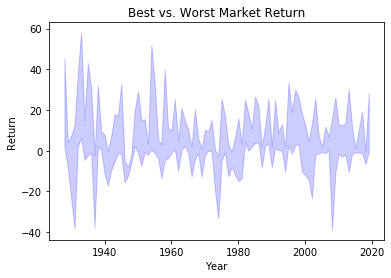

In [304]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.fill_between(
    df["year"],
    min_list,
    max_list,
    color="b",
    alpha=0.2
)

plt.title("Best vs. Worst Market Return")
plt.xlabel("Year")
plt.ylabel("Return")
plt.show()

## Defining an environment

Now let's define a Gym environment so that we can train a contextual bandit to optimize annual investments over that period.

In [305]:
import gym
from gym.spaces import Discrete, Box
from gym.utils import seeding
import numpy as np
import random

class MarketBandit (gym.Env):
    MAX_INFLATION = 100.0
    TICKERS = ["sp500", "t.bill", "t.bond", "corp"]

    ## NB: using a hard-coded full path here - will update CONFIG later
    FILE = "/tmp/market.tsv"
    
    def __init__ (self, config=None):
        self.action_space = Discrete(4)
        self.observation_space = Box(
            low=-self.MAX_INFLATION,
            high=self.MAX_INFLATION,
            shape=(1, )
        )
        self.df = load_market_data(self.FILE)
        self.cur_context = 0.0


    def reset (self):
        self.year = self.df["year"].min()
        self.cur_context = self.df.loc[self.df["year"] == self.year]["inflation"][0]
        self.done = False
        self.info = {}

        return [self.cur_context]
    

    def step (self, action):
        if self.done:
            reward = 0.0
            regret = 0.0
        else:
            row = self.df.loc[self.df["year"] == self.year]

            # calculate reward
            ticker = self.TICKERS[action]
            reward = float(row[ticker])

            # calculate regret
            max_reward = max(map(lambda t: float(row[t]), self.TICKERS))
            regret = round(max_reward - reward)

            # update the context
            self.cur_context = float(row["inflation"])

            # increment the year
            self.year += 1

            if self.year >= self.df["year"].max():
                self.done = True

        context = [self.cur_context]
        #context = self.observation_space.sample()

        self.info = {
            "regret": regret,
            "year": self.year
        }

        #print(action, [context, reward, self.done, self.info])
        return [context, reward, self.done, self.info]


    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

Then let's test the environment to view how it works.

In [306]:
bandit = MarketBandit()
bandit.reset()

for i in range(10):
    action = bandit.action_space.sample()
    obs = bandit.step(action)
    print(action, obs)

1 [[-1.15], 4.28, False, {'regret': 41, 'year': 1929}]
3 [[0.0], 3.02, False, {'regret': 1, 'year': 1930}]
3 [[-2.67], 3.3, False, {'regret': 4, 'year': 1931}]
0 [[-8.93], -38.33, False, {'regret': 51, 'year': 1932}]
1 [[-10.3], 12.68, False, {'regret': 25, 'year': 1933}]
1 [[-5.19], 6.49, False, {'regret': 52, 'year': 1934}]
2 [[3.48], 4.33, False, {'regret': 10, 'year': 1935}]
1 [[2.55], -2.33, False, {'regret': 45, 'year': 1936}]
2 [[1.03], 3.94, False, {'regret': 27, 'year': 1937}]
1 [[3.73], -3.33, False, {'regret': 1, 'year': 1938}]


We can use this environment in a kind of *monte carlo simulation* to measure a baseline for what the rewards would be over a long period if you always used a random action.

In [321]:
done = 1
reward_list = []
iterations = 50000

for i in range(iterations):
    if done == 1:
        bandit.reset()

    action = bandit.action_space.sample()
    obs = bandit.step(action)
    context, reward, done, info = obs
    reward_list.append(reward)
    #print(action, context, reward, done, info)

In [322]:
df = pd.DataFrame(reward_list, columns=["reward"])
df.mean()

reward    3.707063
dtype: float64

Depending on the number of iterations, you'll probably get a value approaching 3.75% as a baseline for random actions. That's more than the -5.64% worst case and must less than 15.18% best case.

## Training a policy in RLlib

Now let's train a policy using our contextual bandit, specifically using *Linear Thompson Sampling* in RLlib.

In [309]:
from ray import tune

stop = {
    "training_iteration": 100
}

config = {
    "env": MarketBandit,
}

analysis = tune.run(
    "contrib/LinTS",
    config=config,
    stop=stop,
    num_samples=3,
    checkpoint_at_end=True
)

Trial name,status,loc
contrib_LinTS_MarketBandit_00000,RUNNING,
contrib_LinTS_MarketBandit_00001,PENDING,
contrib_LinTS_MarketBandit_00002,PENDING,


(pid=63946) 2020-06-08 00:33:27,751	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=63946) 2020-06-08 00:33:27,757	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=63946) /opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=63946)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=63947) 2020-06-08 00:33:27,750	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=63947) 2020-06-08 00:33:27,755	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=63947) /opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=63947)   war

Trial name,status,loc,iter,total time (s),ts,reward
contrib_LinTS_MarketBandit_00000,RUNNING,192.168.1.244:63948,1,0.324666,100,258.36
contrib_LinTS_MarketBandit_00001,RUNNING,,,,,
contrib_LinTS_MarketBandit_00002,RUNNING,,,,,


Result for contrib_LinTS_MarketBandit_00001:
  custom_metrics: {}
  date: 2020-06-08_00-33-28
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 610.7899999999998
  episode_reward_mean: 610.7899999999998
  episode_reward_min: 610.7899999999998
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: 7a0f69c0bd104b5e98f860493a8014a7
  experiment_tag: '1'
  grad_time_ms: 0.453
  hostname: derwen
  info:
    grad_time_ms: 0.453
    learner:
      cumulative_regret: 911.0
      update_latency: 0.00018310546875
    num_steps_sampled: 100
    num_steps_trained: 100
    opt_peak_throughput: 2207.18
    opt_samples: 1.0
    sample_peak_throughput: 387.086
    sample_time_ms: 2.583
    update_time_ms: 0.002
  iterations_since_restore: 1
  learner:
    cumulative_regret: 911.0
    update_latency: 0.00018310546875
  node_ip: 192.168.1.244
  num_healthy_workers: 0
  num_steps_sampled: 100
  num_steps_trained: 100
  off_policy_estimator: {}
  opt_peak_throughput: 2207.18
  opt_samples

Trial name,status,loc,iter,total time (s),ts,reward
contrib_LinTS_MarketBandit_00000,RUNNING,192.168.1.244:63948,16,5.09794,1600,486.917
contrib_LinTS_MarketBandit_00001,RUNNING,192.168.1.244:63946,16,5.11372,1600,593.437
contrib_LinTS_MarketBandit_00002,RUNNING,192.168.1.244:63947,16,5.0454,1600,552.631


Result for contrib_LinTS_MarketBandit_00002:
  custom_metrics: {}
  date: 2020-06-08_00-33-33
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 704.4300000000001
  episode_reward_mean: 560.3322222222223
  episode_reward_min: 351.38
  episodes_this_iter: 1
  episodes_total: 18
  experiment_id: 4603f948f3df4b1e94e947867868b5cd
  experiment_tag: '2'
  grad_time_ms: 0.534
  hostname: derwen
  info:
    grad_time_ms: 0.534
    learner:
      cumulative_regret: 15156.0
      update_latency: 0.0002853870391845703
    num_steps_sampled: 1700
    num_steps_trained: 1700
    opt_peak_throughput: 1871.538
    opt_samples: 1.0
    sample_peak_throughput: 348.773
    sample_time_ms: 2.867
    update_time_ms: 0.002
  iterations_since_restore: 17
  learner:
    cumulative_regret: 15156.0
    update_latency: 0.0002853870391845703
  node_ip: 192.168.1.244
  num_healthy_workers: 0
  num_steps_sampled: 1700
  num_steps_trained: 1700
  off_policy_estimator: {}
  opt_peak_throughput: 1871.538
  

Trial name,status,loc,iter,total time (s),ts,reward
contrib_LinTS_MarketBandit_00000,RUNNING,192.168.1.244:63948,31,9.93779,3100,503.428
contrib_LinTS_MarketBandit_00001,RUNNING,192.168.1.244:63946,31,9.91669,3100,582.777
contrib_LinTS_MarketBandit_00002,RUNNING,192.168.1.244:63947,31,9.82134,3100,560.216


Result for contrib_LinTS_MarketBandit_00000:
  custom_metrics: {}
  date: 2020-06-08_00-33-38
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 670.7699999999998
  episode_reward_mean: 503.12285714285724
  episode_reward_min: 258.36
  episodes_this_iter: 1
  episodes_total: 35
  experiment_id: b805fe7c933a4d6a8039e08ab48da90c
  experiment_tag: '0'
  grad_time_ms: 0.574
  hostname: derwen
  info:
    grad_time_ms: 0.574
    learner:
      cumulative_regret: 30416.0
      update_latency: 0.0007669925689697266
    num_steps_sampled: 3200
    num_steps_trained: 3200
    opt_peak_throughput: 1743.124
    opt_samples: 1.0
    sample_peak_throughput: 368.312
    sample_time_ms: 2.715
    update_time_ms: 0.003
  iterations_since_restore: 32
  learner:
    cumulative_regret: 30416.0
    update_latency: 0.0007669925689697266
  node_ip: 192.168.1.244
  num_healthy_workers: 0
  num_steps_sampled: 3200
  num_steps_trained: 3200
  off_policy_estimator: {}
  opt_peak_throughput: 1743.124
 

Trial name,status,loc,iter,total time (s),ts,reward
contrib_LinTS_MarketBandit_00000,RUNNING,192.168.1.244:63948,45,14.8435,4500,517.234
contrib_LinTS_MarketBandit_00001,RUNNING,192.168.1.244:63946,45,14.6797,4500,593.13
contrib_LinTS_MarketBandit_00002,RUNNING,192.168.1.244:63947,45,14.6496,4500,561.441


Result for contrib_LinTS_MarketBandit_00000:
  custom_metrics: {}
  date: 2020-06-08_00-33-43
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 695.77
  episode_reward_mean: 517.5286000000001
  episode_reward_min: 258.36
  episodes_this_iter: 1
  episodes_total: 50
  experiment_id: b805fe7c933a4d6a8039e08ab48da90c
  experiment_tag: '0'
  grad_time_ms: 0.415
  hostname: derwen
  info:
    grad_time_ms: 0.415
    learner:
      cumulative_regret: 42969.0
      update_latency: 0.0002338886260986328
    num_steps_sampled: 4600
    num_steps_trained: 4600
    opt_peak_throughput: 2411.906
    opt_samples: 1.0
    sample_peak_throughput: 484.695
    sample_time_ms: 2.063
    update_time_ms: 0.002
  iterations_since_restore: 46
  learner:
    cumulative_regret: 42969.0
    update_latency: 0.0002338886260986328
  node_ip: 192.168.1.244
  num_healthy_workers: 0
  num_steps_sampled: 4600
  num_steps_trained: 4600
  off_policy_estimator: {}
  opt_peak_throughput: 2411.906
  opt_samples

Trial name,status,loc,iter,total time (s),ts,reward
contrib_LinTS_MarketBandit_00000,RUNNING,192.168.1.244:63948,58,19.3995,5800,527.81
contrib_LinTS_MarketBandit_00001,RUNNING,192.168.1.244:63946,58,19.3299,5800,594.27
contrib_LinTS_MarketBandit_00002,RUNNING,192.168.1.244:63947,59,19.6095,5900,564.281


Result for contrib_LinTS_MarketBandit_00000:
  custom_metrics: {}
  date: 2020-06-08_00-33-48
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 695.77
  episode_reward_mean: 528.5258461538461
  episode_reward_min: 258.36
  episodes_this_iter: 1
  episodes_total: 65
  experiment_id: b805fe7c933a4d6a8039e08ab48da90c
  experiment_tag: '0'
  grad_time_ms: 0.542
  hostname: derwen
  info:
    grad_time_ms: 0.542
    learner:
      cumulative_regret: 55197.0
      update_latency: 0.00033473968505859375
    num_steps_sampled: 6000
    num_steps_trained: 6000
    opt_peak_throughput: 1845.76
    opt_samples: 1.0
    sample_peak_throughput: 374.051
    sample_time_ms: 2.673
    update_time_ms: 0.002
  iterations_since_restore: 60
  learner:
    cumulative_regret: 55197.0
    update_latency: 0.00033473968505859375
  node_ip: 192.168.1.244
  num_healthy_workers: 0
  num_steps_sampled: 6000
  num_steps_trained: 6000
  off_policy_estimator: {}
  opt_peak_throughput: 1845.76
  opt_samples

Trial name,status,loc,iter,total time (s),ts,reward
contrib_LinTS_MarketBandit_00000,RUNNING,192.168.1.244:63948,72,24.454,7200,532.194
contrib_LinTS_MarketBandit_00001,RUNNING,192.168.1.244:63946,72,24.4,7200,592.458
contrib_LinTS_MarketBandit_00002,RUNNING,192.168.1.244:63947,73,24.6221,7300,565.366


Result for contrib_LinTS_MarketBandit_00000:
  custom_metrics: {}
  date: 2020-06-08_00-33-53
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 749.2900000000001
  episode_reward_mean: 535.655925925926
  episode_reward_min: 258.36
  episodes_this_iter: 1
  episodes_total: 81
  experiment_id: b805fe7c933a4d6a8039e08ab48da90c
  experiment_tag: '0'
  grad_time_ms: 0.475
  hostname: derwen
  info:
    grad_time_ms: 0.475
    learner:
      cumulative_regret: 67612.0
      update_latency: 0.0003409385681152344
    num_steps_sampled: 7400
    num_steps_trained: 7400
    opt_peak_throughput: 2105.786
    opt_samples: 1.0
    sample_peak_throughput: 425.369
    sample_time_ms: 2.351
    update_time_ms: 0.002
  iterations_since_restore: 74
  learner:
    cumulative_regret: 67612.0
    update_latency: 0.0003409385681152344
  node_ip: 192.168.1.244
  num_healthy_workers: 0
  num_steps_sampled: 7400
  num_steps_trained: 7400
  off_policy_estimator: {}
  opt_peak_throughput: 2105.786
  o

Trial name,status,loc,iter,total time (s),ts,reward
contrib_LinTS_MarketBandit_00000,RUNNING,192.168.1.244:63948,87,29.5138,8700,537.259
contrib_LinTS_MarketBandit_00001,RUNNING,192.168.1.244:63946,86,29.1877,8600,589.974
contrib_LinTS_MarketBandit_00002,RUNNING,192.168.1.244:63947,87,29.3863,8700,566.402


Result for contrib_LinTS_MarketBandit_00000:
  custom_metrics: {}
  date: 2020-06-08_00-33-59
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 749.2900000000001
  episode_reward_mean: 537.280412371134
  episode_reward_min: 258.36
  episodes_this_iter: 1
  episodes_total: 97
  experiment_id: b805fe7c933a4d6a8039e08ab48da90c
  experiment_tag: '0'
  grad_time_ms: 0.518
  hostname: derwen
  info:
    grad_time_ms: 0.518
    learner:
      cumulative_regret: 81118.0
      update_latency: 0.00026702880859375
    num_steps_sampled: 8900
    num_steps_trained: 8900
    opt_peak_throughput: 1929.746
    opt_samples: 1.0
    sample_peak_throughput: 412.128
    sample_time_ms: 2.426
    update_time_ms: 0.002
  iterations_since_restore: 89
  learner:
    cumulative_regret: 81118.0
    update_latency: 0.00026702880859375
  node_ip: 192.168.1.244
  num_healthy_workers: 0
  num_steps_sampled: 8900
  num_steps_trained: 8900
  off_policy_estimator: {}
  opt_peak_throughput: 1929.746
  opt_s

Trial name,status,loc,iter,total time (s),ts,reward
contrib_LinTS_MarketBandit_00000,TERMINATED,,100,34.0147,10000,551.137
contrib_LinTS_MarketBandit_00001,TERMINATED,,100,34.0912,10000,590.594
contrib_LinTS_MarketBandit_00002,TERMINATED,,100,33.9252,10000,566.802


## Analyzing the results

Now we can analyze the rewards and cumulative regrets of these trials.

In [310]:
df = pd.DataFrame()

for key, df_trial in analysis.trial_dataframes.items():
    df = df.append(df_trial, ignore_index=True)
    
df.head()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_steps_trained,num_steps_sampled,sample_time_ms,grad_time_ms,update_time_ms,...,info/update_time_ms,info/opt_peak_throughput,info/sample_peak_throughput,info/opt_samples,learner/cumulative_regret,learner/update_latency,perf/cpu_util_percent,perf/ram_util_percent,info/learner/cumulative_regret,info/learner/update_latency
0,258.36,258.36,258.3600,91.0,1,100,100,2.478,0.437,0.002,...,0.002,2290.718,403.593,1.0,1326.0,0.000205,25.0,68.2,1326.0,0.000205
1,384.21,258.36,321.2850,91.0,1,200,200,2.814,0.507,0.002,...,0.002,1970.637,355.401,1.0,2365.0,0.000479,NaN,NaN,2365.0,0.000479
2,384.21,258.36,330.4600,91.0,1,300,300,2.572,0.479,0.002,...,0.002,2085.992,388.775,1.0,3580.0,0.000276,84.7,68.4,3580.0,0.000276
3,457.79,258.36,362.2925,91.0,1,400,400,2.689,0.468,0.003,...,0.003,2137.334,371.908,1.0,4583.0,0.000191,NaN,NaN,4583.0,0.000191
4,457.79,258.36,362.7560,91.0,1,500,500,2.099,0.385,0.002,...,0.002,2596.128,476.512,1.0,5505.0,0.000256,80.0,68.4,5505.0,0.000256


In [311]:
rewards = df \
    .groupby("num_steps_trained")["episode_reward_mean"] \
    .aggregate(["mean", "max", "min", "std"])

rewards

,mean,max,min,std
num_steps_trained,,,,
100,495.690000,617.920000,258.3600,205.564724
200,508.178333,649.020000,321.2850,168.650896
300,509.030000,650.963333,330.4600,163.362421
400,484.330000,593.602500,362.2925,116.182133
500,485.069333,588.586000,362.7560,114.082353
...,...,...,...,...
9600,568.525733,588.782200,548.6276,20.079698
9700,568.932300,588.491300,550.1490,19.182916
9800,568.081467,589.268600,548.3468,20.499529


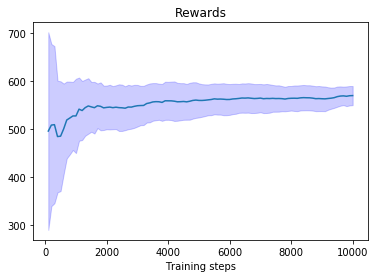

In [312]:
plt.plot(rewards["mean"])
plt.fill_between(
    rewards.index,
    rewards["mean"] - rewards["std"],
    rewards["mean"] + rewards["std"],
    color="b",
    alpha=0.2
)

plt.title("Rewards")
plt.xlabel("Training steps")
plt.show()

In [313]:
regrets = df \
    .groupby("num_steps_trained")["learner/cumulative_regret"] \
    .aggregate(["mean", "max", "min", "std"])

regrets

,mean,max,min,std
num_steps_trained,,,,
100,1053.666667,1326.0,911.0,235.937139
200,1961.666667,2365.0,1635.0,370.989667
300,2976.333333,3580.0,2504.0,549.891201
400,4012.666667,4583.0,3515.0,537.695391
500,4887.666667,5505.0,4364.0,576.238087
...,...,...,...,...
9600,84729.000000,87297.0,82225.0,2536.605606
9700,85642.000000,88186.0,83103.0,2541.503689
9800,86401.333333,88947.0,83849.0,2549.006539


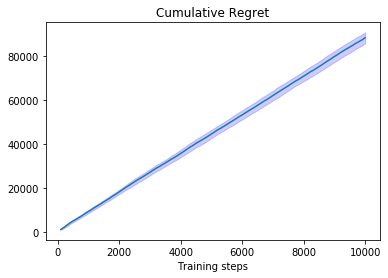

In [314]:
plt.plot(regrets["mean"])
plt.fill_between(
    regrets.index,
    regrets["mean"] - regrets["std"],
    regrets["mean"] + regrets["std"],
    color="b",
    alpha=0.2
)

plt.title("Cumulative Regret")
plt.xlabel("Training steps")
plt.show()

## Evaluating the trained policy

Overall, how well did the trained policy perform? The results should be better than random, but less than the best case.

In [315]:
print("{:5.2f}% optimized return annualized".format(max(rewards["mean"]) / n_years))

 6.19% optimized return annualized


That's better than the random action baseline of 3.75%, but no where near the best case scenario of 15.18% return. 

Note that investing solely in the S&P stock index which would have produced better than 8% return over that period -- that is, if one could wait 92 years. However, investing one's entire portfolio into stocks can become quite a risky policy in the short-term, so we were exploring how to balance a portfolio given only limited information.

In any case, the contextual bandit performed well considering that it could only use *inflation* for the context of its decisions, and could only take actions once each year.

---

## Misc.

Restore trainer from checkpoint

In [316]:
from ray.rllib.contrib.bandits.agents import LinTSTrainer
from ray.rllib.contrib.bandits.agents.lin_ts import TS_CONFIG

TS_CONFIG["env"] = MarketBandit

trial = analysis.trials[0]
trainer = LinTSTrainer(config=TS_CONFIG)
trainer.restore(trial.checkpoint.value)

2020-06-08 00:34:04,039	INFO trainable.py:217 -- Getting current IP.
2020-06-08 00:34:04,040	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-06-08 00:34:04,043	INFO trainable.py:217 -- Getting current IP.
2020-06-08 00:34:04,045	INFO trainable.py:423 -- Restored on 192.168.1.244 from checkpoint: /Users/paco/ray_results/contrib/LinTS/contrib_LinTS_MarketBandit_0_2020-06-08_00-33-22z9zig65x/checkpoint_100/checkpoint-100
2020-06-08 00:34:04,047	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': 10000, '_time_total': 34.0146963596344, '_episodes_total': 109}


Get model to plot arm weights distribution

In [317]:
model = trainer.get_policy().model
means = [model.arms[i].theta.numpy() for i in range(3)]
covs = [model.arms[i].covariance.numpy() for i in range(3)]

In [318]:
model.arms[0].theta.numpy()

array([1.2260698], dtype=float32)